# From Causal Trees to Forests

*How to use regression trees to do policy targeting.*

In my [previous blog post](https://medium.com/towards-data-science/understanding-causal-trees-920177462149), we have seen how to use **causal trees** to estimate heterogeneous treatment effects of a policy. If you haven't read it, I recommend starting there first, since we are going to take the content of that article for granted and start from there.

Why heterogenous treatment effects (HTE)? The estimation of heterogeneous treatments effects is important because it allows us to do **targeting**. Knowing which customers are more likely to react to a discount allows a company to spend less money by offering fewer but better targeted discounts. This works also for negative effects: knowing for which patients a certain drug has side effects allows a pharmaceutical company to warn or exclude them from the treatment. There is also a more subtle advantage of estimating heterogeneous treatment effects: knowing **for whom** a treatment works allows us to better understand **how** a treatment works. Knowing that the effect of a discount does not depend on the income of its recipient but rather by its buying habits  tells us that maybe it is not a matter of money, but rather a matter of attention or loyalty.

In this article, we will explore an extention of causal trees: causal forests. Exactly as random forests extend regression trees by averaging multiple bootstrapped trees together, causal forests extend causal trees. The main difference comes from the inference perspective, which is less straighforward. We are also going to see how to compare outputs of different HTE estimation algorithms and how to use them for **policy targeting**.

## Online Discounts

For the rest of the article, we resume the toy example used in the [causal trees article](https://medium.com/towards-data-science/understanding-causal-trees-920177462149): we assume we are an **online store** and we are interested in understanding whether offering discounts to new customers increases their expenditure in the store.

<img src="fig/causal_forests1.jpg" width="300px"/>

To understand whether and how much the discounts are effective we run an **A/B test**: whenever a new user visits our online store, we randomly decide whether to offer them the discount or not. I import the data-generating process `dgp_online_discounts()` from [`src.dgp`](https://github.com/matteocourthoud/Blog-Posts/blob/main/notebooks/src/dgp.py). I also import some plotting functions and libraries from [`src.utils`](https://github.com/matteocourthoud/Blog-Posts/blob/main/notebooks/src/utils.py). To include not only code but also data and tables, I use [Deepnote](https://deepnote.com/), a Jupyter-like web-based collaborative notebook environment.

In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

from src.utils import *
from src.dgp import dgp_online_discounts

In [2]:
dgp = dgp_online_discounts(n=100_000)
df = dgp.generate_data()
df.head()

,time,device,browser,region,discount,spend
0,10.78,mobile,edge,9,0,0.46
1,0.57,desktop,firefox,9,1,11.04
2,3.74,mobile,safari,7,0,1.81
3,13.37,desktop,other,5,0,31.90
4,0.71,mobile,explorer,2,0,15.42


We have data on 100.000 store visitors, for whom we observe the `time` of the day the acessed the website, the `device` they use, their `browser`, and their geographical `region`. We also see whether they were offered the `discount`, our treatment, and what is their `spend`, the outcome of interest.

Since the treatment was randomly assigned, we can use a simple **difference-in-means** estimator to estimate the treatment effect. We expect the treatment and control group to be similar, except for the `discount`, therefore we can causally attribute any difference in `spend` to the `discount`.

In [3]:
smf.ols('spend ~ discount', df).fit().summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,5.0306,0.045,110.772,0.000,4.942,5.120
discount,1.9492,0.064,30.346,0.000,1.823,2.075


The discount seems to be effective: on average the spend in the treatment group increases by 1.95$. But are all customers equally affected?

To answer this question, we would like to estimate **heterogeneous treatment effects**, possibly at the individual level. 

## Causal Forests

There are many different options to compute heterogeneous treatment effects. The simplest one is to interact the outcome of interest with a dimension of heterogeneity. The problem with this approach is which variable to pick. Sometimes we have prior information that might guide out actions; for example, we might know that `mobile` users on average spend more than `desktop` users. Other times, we might be interested in one dimension for business reasons; for example we might want to invest more in a certain `region`. However, when we do not extra information we would like this process to be data-driven.

In the [previous article](https://medium.com/towards-data-science/understanding-causal-trees-920177462149) we have explored one data-drive approach to estimate heterogeneous treatment effects: **causal trees**. We will now expand them to causal forests. However, before we start, we have to give an introduction to its non-causal cousing: random forests.

<img src="fig/causal_forests2.jpg" width="300px"/>

[**Random forests**](https://en.wikipedia.org/wiki/Random_forest), as the name suggests, are an extension of regression trees, adding two separate sources of randomness of top of them. In particular, a random forest algorithm takes the predictions of many different regression trees, each trained on a bootstrapped sample of the data, and averages them together. This procedure is generally known as [**bagging**](https://en.wikipedia.org/wiki/Bootstrap_aggregating), boostrap-aggregating, and can be applied to any prediction algorithm and is not specific to random forest. The additional source of randomness comes from feature selection since at each split, only a random subset of all the features $X$ is considered for the optimal split.

These two extra sources of randomness are extremely important and controbute to a superior performance of random forests. First of all, bagging allows random forests to **produce smoother** prediction than regression trees by averaging multiple discrete predictions. Random feature selection instead allows random forests to **explore the feature space** more in depth, allowing it to discover more interations than simple regression trees. In fact, there might be interactions between variables that are on their own not very predictive (and therefore would not generate splits) but together very powerful.

Causal Forests are the equivalent of random forests, but for the estimation of heterogeneous treatment effects, exaxtly as for causal trees and regression trees. Exactly as for Causal Trees, we have a fundamental problem: we are interested in predicting an object that we do not observe: the individua treatment effects $\tau_i$. The solution is to create an auxiliary outcome variable $Y^*$ whose expected value for each single observation is exactly the treatment effect.

$$
Y_i^* = \frac{Y_i}{D_i \cdot p(X_i) - (1-D_i) \cdot (1-p(X_i))}
$$

If you want to know more details on why this variable is unbiased for the individual treatment effect, have a look at my [previous post](https://towardsdatascience.com/920177462149) where I go more in detail. In short, you can interpret $Y_i^*$ as the difference-in-means estimator for a single observation.

Once we have an outcome variable, there are still a couple of things we need to do in order to use Random Forests to estimate heterogeneous treatment effects. First, we need to build trees that have an equal number of treated and control units in each leaf. Second, we need to use different samples to build the tree and evaluate it, i.e. compute the average outcome per leaf. This procedure is often referred to as **honest trees** and it's extremely helpful for inference, since we can treat the sample of each leaf as independent from the tree structure. 

Before we go into the estimation, let's first generate dummy variables for our categorical variables, `device`, `browser` and `region`.

In [4]:
df_dummies = pd.get_dummies(df[dgp.X[1:]], drop_first=True)
df = pd.concat([df, df_dummies], axis=1)
X = ['time'] + list(df_dummies.columns)

We can now estimate the heterogeneous treatment effects using the Random Forest algorithm. Luckily, we don't have to do all this by hand, but there is a great implementation of Causal Trees and Forests in Microsoft's [EconML](https://econml.azurewebsites.net/) package. We will use the `CausalForestDML` function. We set a seed for reproducibility.

In [5]:
from econml.dml import CausalForestDML

np.random.seed(0)
forest_model = CausalForestDML(max_depth=3)
forest_model = forest_model.fit(Y=df[dgp.Y], X=df[X], T=df[dgp.D])

Differently from Causal Trees, Causal Forests are harder to interpret since we cannot visualize every single tree. We can use the `SingleTreeCateInterpreter` function to plot an equivalent representation of the Causal Forest algorithm.

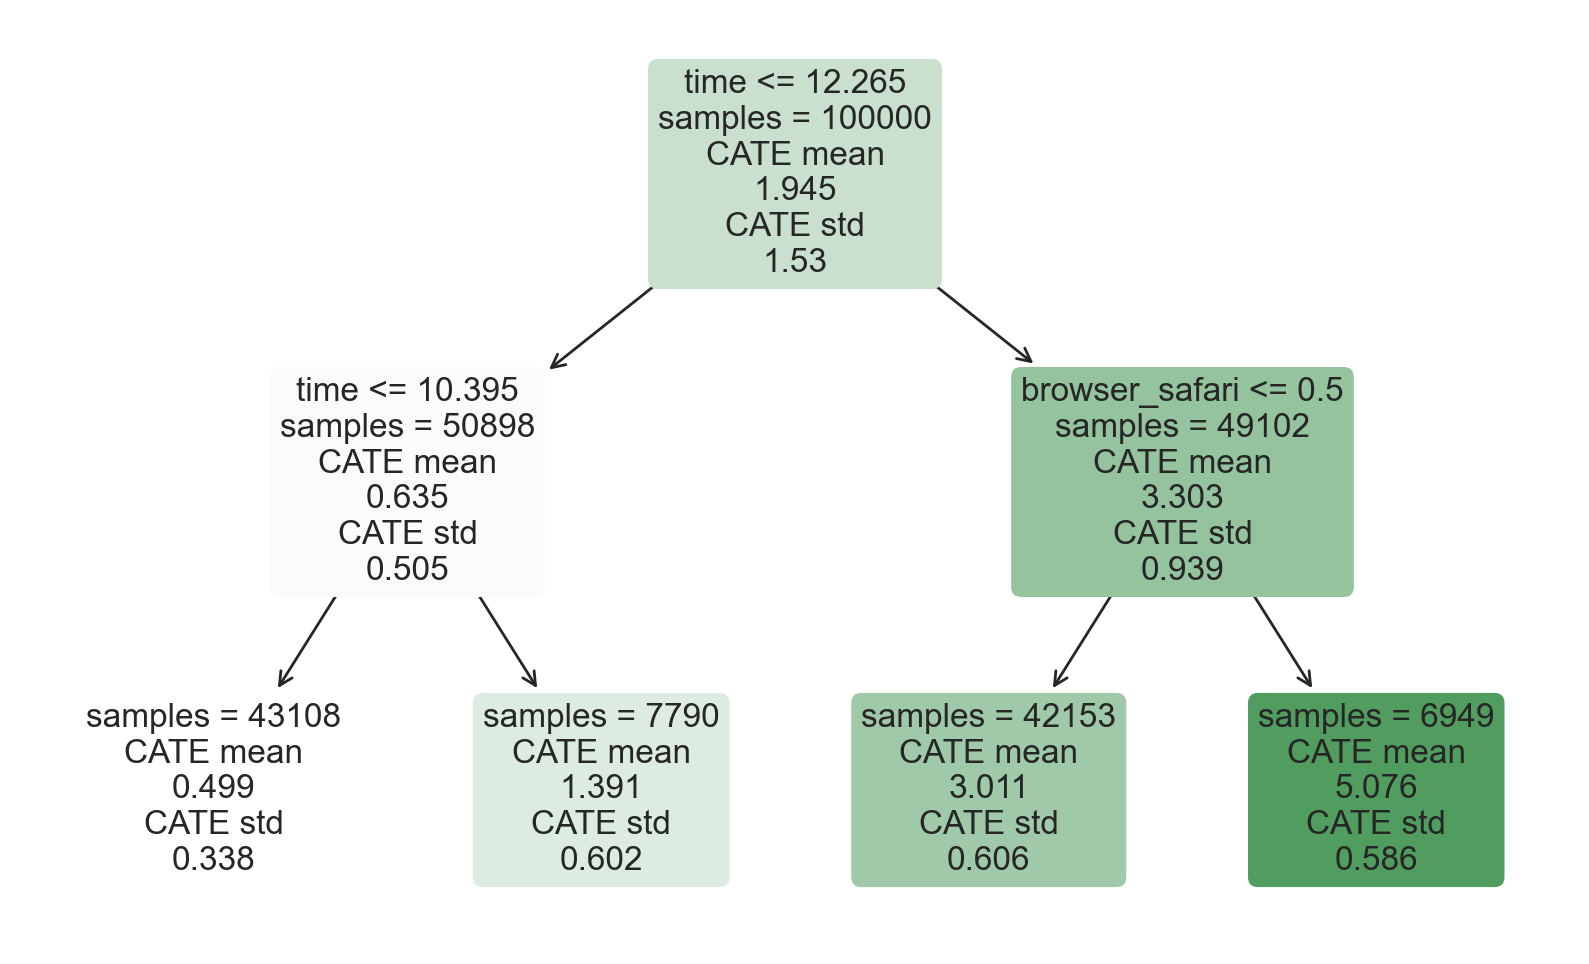

In [6]:
from econml.cate_interpreter import SingleTreeCateInterpreter
%matplotlib inline

intrp = SingleTreeCateInterpreter(max_depth=2).interpret(forest_model, df[X])
intrp.plot(feature_names=X, fontsize=12)

We can interpret the tree diagram exactly as for the Causal Tree model. On the top, we can see the average $Y^*$ in the data, $1.917$. Starting from there, the data gets split into different branches, according to the rules highlighted at the top of each node. For example, the first node splits the data into two groups of size $46878$ and $53122$ depending on whether the `time` is later than $11.295$. At the bottom, we have our final partitions, with the predicted values. For example, the leftmost leaf contains $40191$ observation with `time` earlier than $11.295$ and non-Safari `browser`, for which we predict a spend of $0.264$. Darker node colors indicate higher prediction values.

The problem with this representation is that, differently from the case of Causal Trees, it is only an interpretation of the model. Since Causal Forests are made of many bootstrapped trees, there is no way to directly inspect each decision tree. One way to understand which feature is most important in detemining the tree split is the so-called [feature importance](https://scikit-learn.org/stable/auto_examples/ensemble/plot_forest_importances.html).

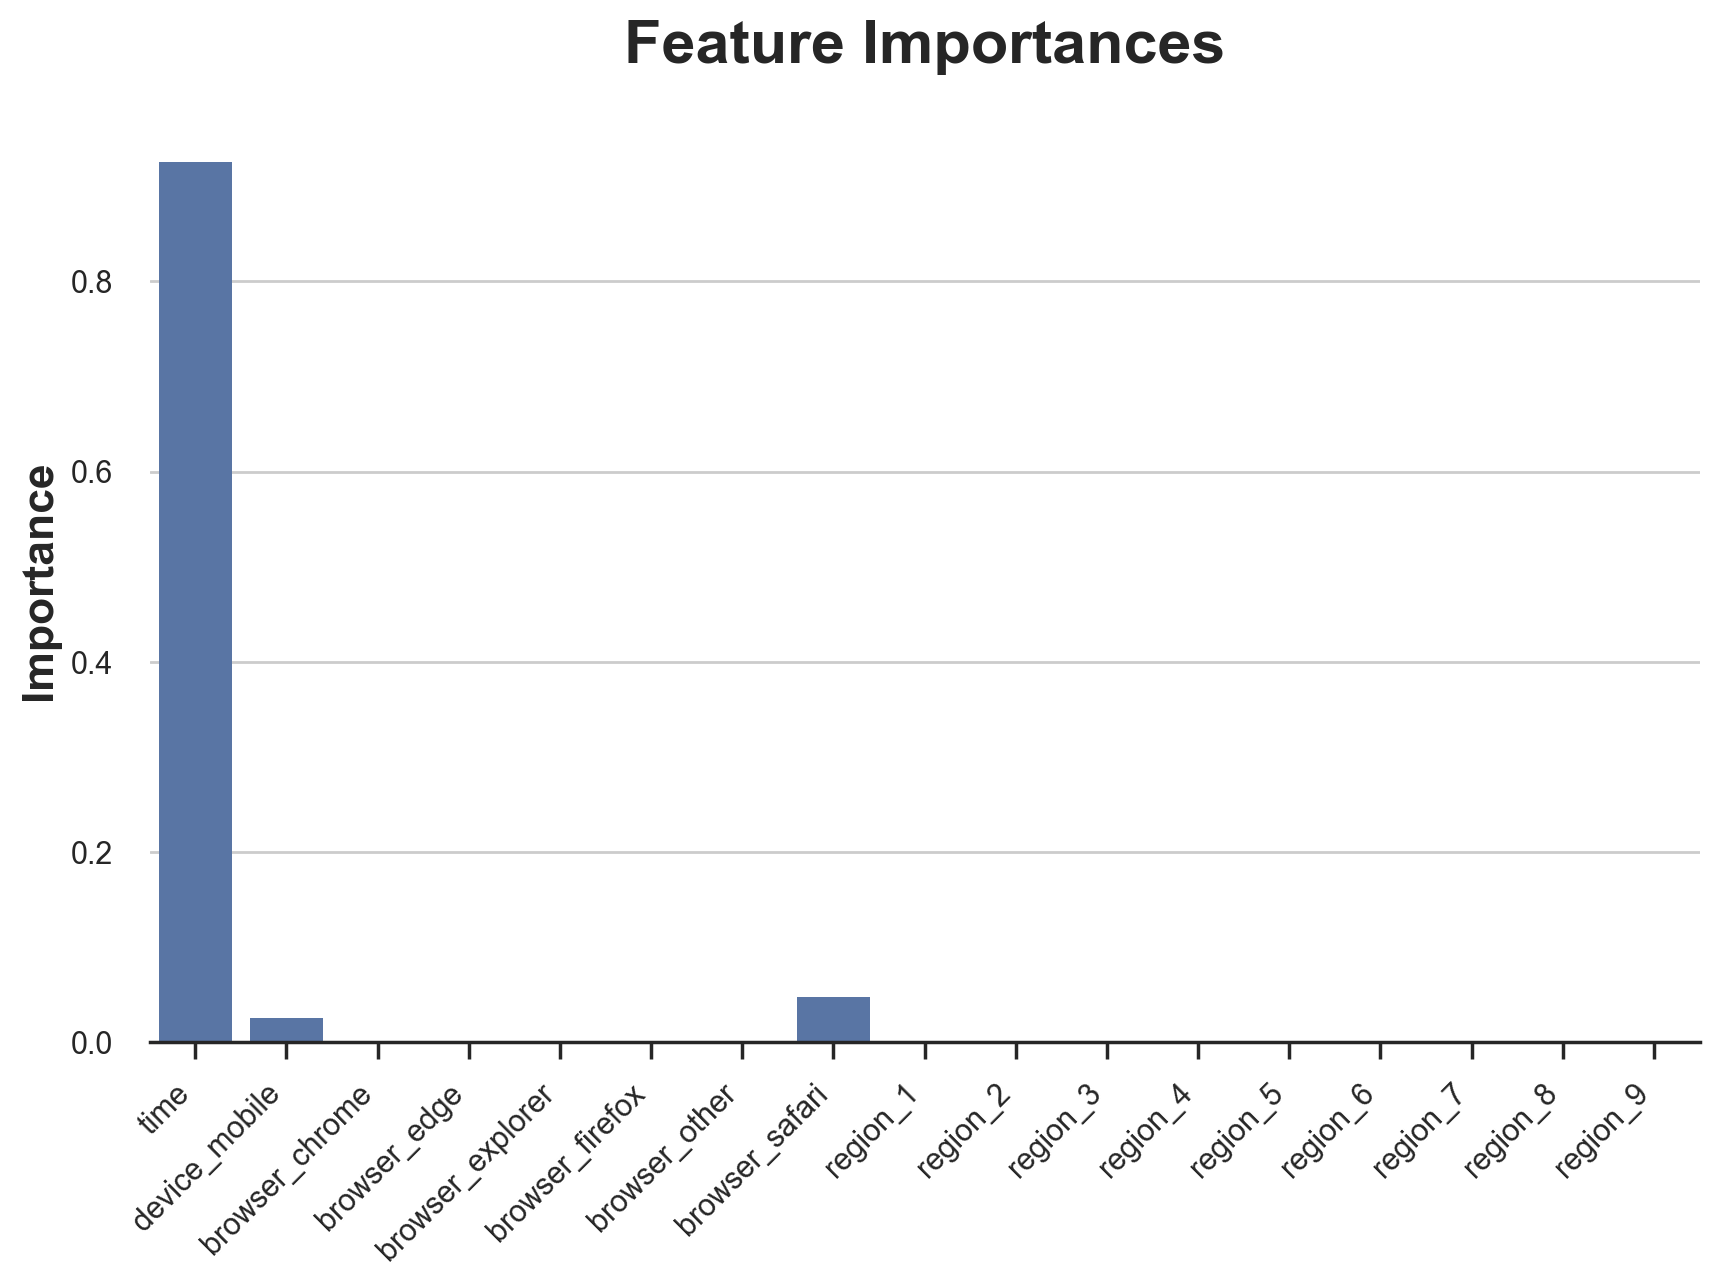

In [7]:
fig, ax = plt.subplots()
sns.barplot(x=X, y=forest_model.feature_importances()[0], color='C0').set(
    title='Feature Importances', ylabel='Importance')
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha="right");

Clearly `time` is the first dimension of heterogeneity, followed by `device` (mobile in particular) and `browser` (safari in particular). Other dimensions do not matter much.

Let's now check the model performance.

### Performance

Since we control the data generating process, we can do something that is not possible with real data: check the predicted treatment effects against the true ones. The `generate_potential_outcomes()` function loads the data with both potential outcomes for each observation, under both treatment (`outcome_t`) and control (`outcome_c`). Let's start first by evaluating how well the algorithm predicts the effects along the discrete dimensions of the data.

In [8]:
def compute_discrete_effects(df, hte_model):
    temp_df = df.copy()
    temp_df.time = 0
    temp_df = dgp.add_treatment_effect(temp_df)
    temp_df = temp_df.rename(columns={'effect_on_spend': 'True'})
    temp_df['Predicted'] = hte_model.effect(temp_df[X])
    df_effects = pd.DataFrame()
    for var in X[1:]:
        for effect in ['True', 'Predicted']:
            v = temp_df.loc[temp_df[var]==1, effect].mean() - temp_df[effect][temp_df[var]==0].mean()
            effect_var = {'Variable': [var], 'Effect': [effect], 'Value': [v]}
            df_effects = pd.concat([df_effects, pd.DataFrame(effect_var)]).reset_index(drop=True)
    return df_effects, temp_df['Predicted'].mean()

In [9]:
df_effects, avg_effect_notime = compute_discrete_effects(df, forest_model)

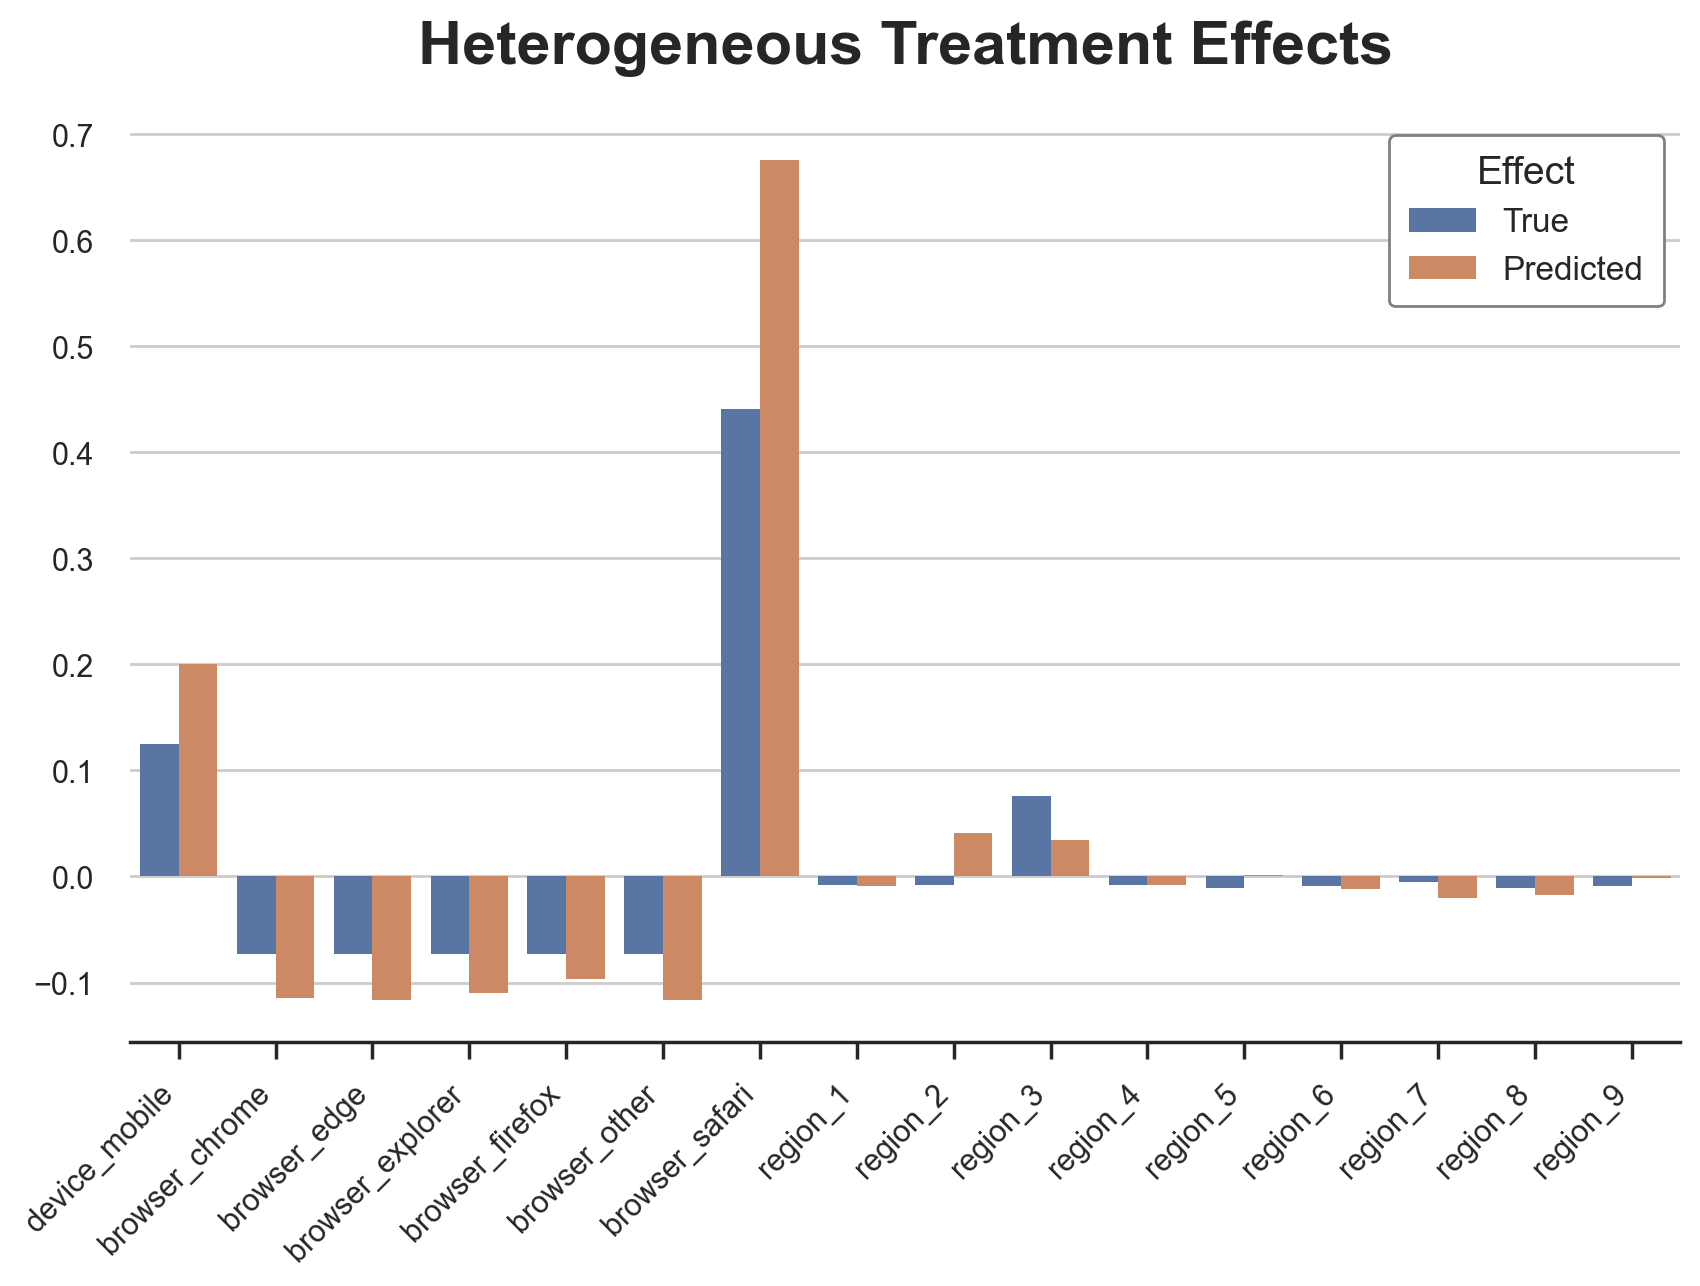

In [10]:
fig, ax = plt.subplots()
sns.barplot(data=df_effects, x="Variable", y="Value", hue="Effect", ax=ax).set(
    xlabel='', ylabel='', title='Heterogeneous Treatment Effects')
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha="right");

The Causal Forest algorithm is pretty good at predicting the treatment effects related to the categorical variables. As for Causal Trees, this is expected since the algorithm has a very discrete nature. However, differently from Causal Trees, the predictions are more nuanced.

We can now do a more relevant test: how well the algorithm performs with a continuous variable such as `time`? First, let's again isolate the predicted treatment effects on `time` and ignore the other covariates.

In [11]:
def compute_time_effect(df, hte_model, avg_effect_notime):
    df_time = df.copy()
    df_time[[X[1:]] + ['device', 'browser', 'region']] = 0
    df_time = dgp.add_treatment_effect(df_time)
    df_time['predicted'] = hte_model.effect(df_time[X]) + avg_effect_notime
    return df_time

In [12]:
df_time = compute_time_effect(df, forest_model, avg_effect_notime)

We now plot the predicted treatment effects against the true ones, along the `time` dimension.

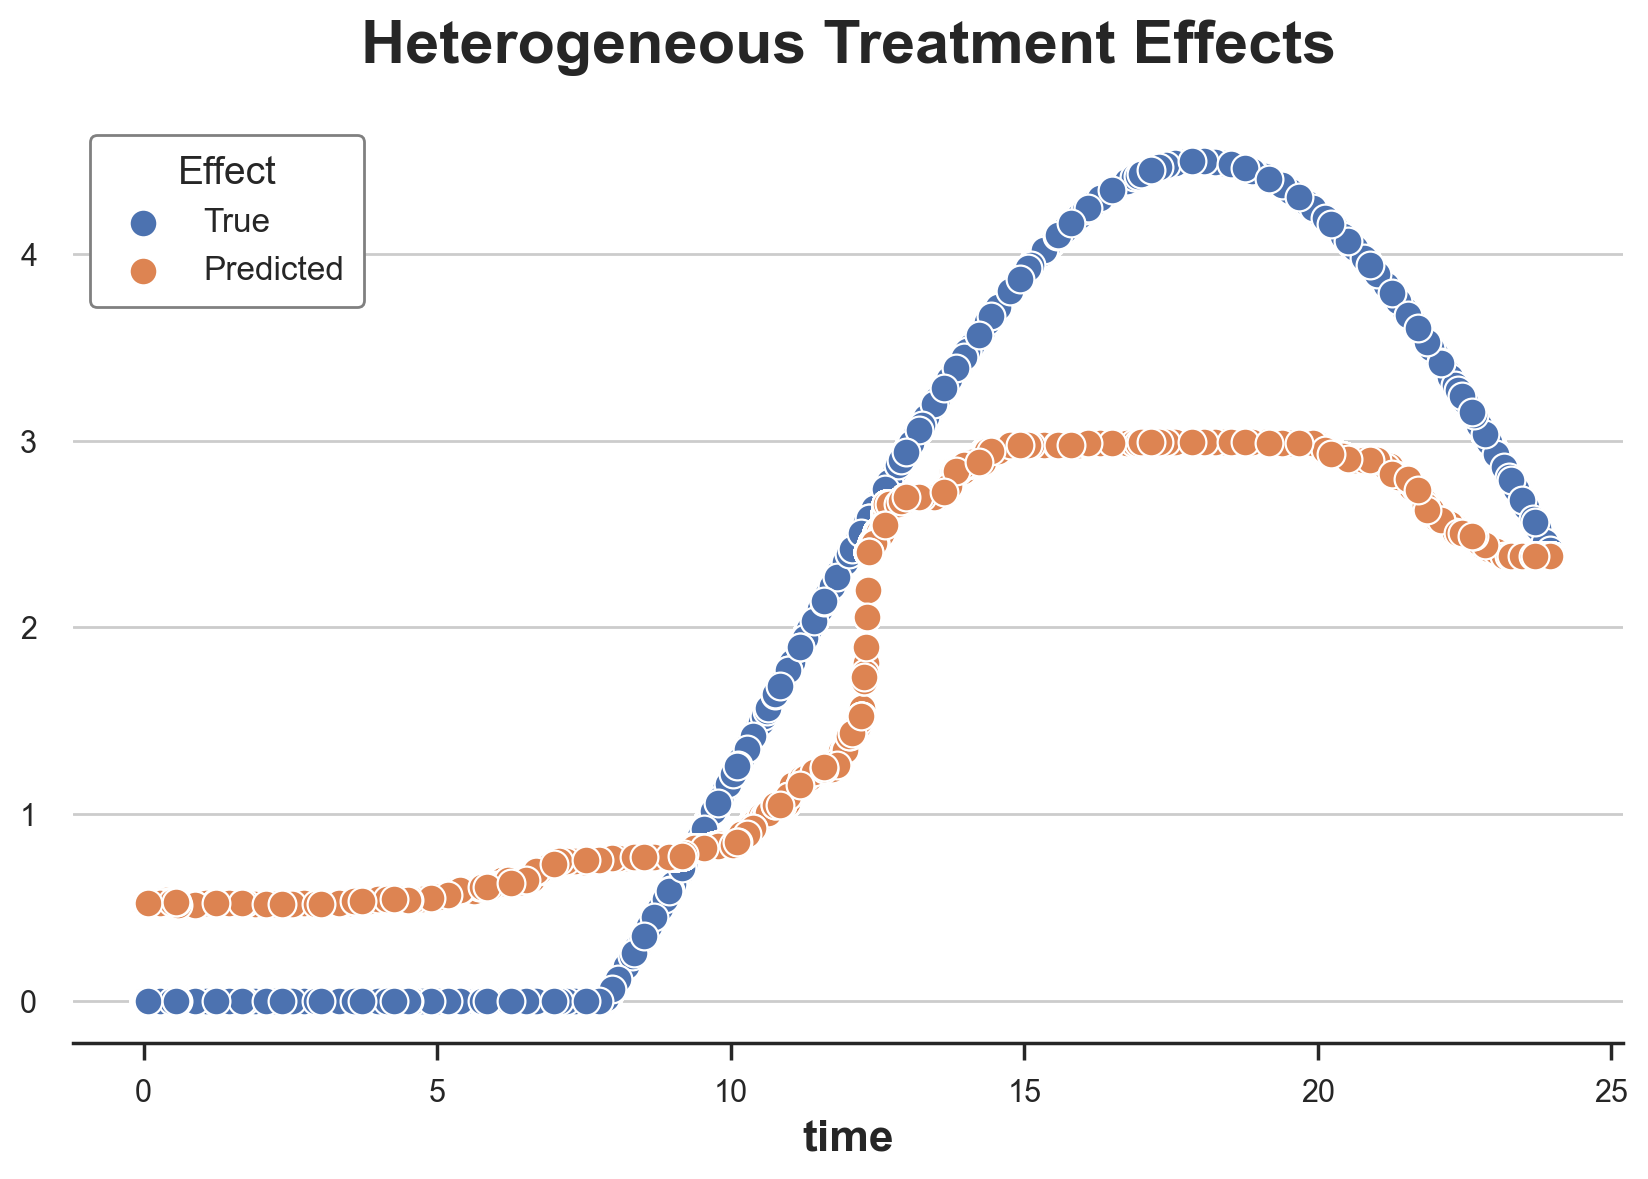

In [13]:
sns.scatterplot(x='time', y='effect_on_spend', data=df_time, label='True')
sns.scatterplot(x='time', y='predicted', data=df_time, label='Predicted').set(
    ylabel='', title='Heterogeneous Treatment Effects')
plt.legend(title='Effect');

We can now fully appreciate the difference between Causal Trees and Forests: while in the case of Causal Trees the estimates were essentially a very coarse step function, we can now see how Causal Forests produce **smoother estimates**.

We have now explored the model, it's time to use it!

## Policy

Suppose that we were considering offering a 4\$ discount to new customers that visit our online store.

In [14]:
cost = 4

For which customers is the discount effective? We have estimated an average treatment effect of 1.9492\$ which means that the discount is not really profitable on average. However, we are now able to target single individuals and we can offer the discount only to a subset of the incoming customers. We will now explore how to do **policy targeting** and in order to get a better understanding of the quality of the targeting, we will use the Causal Tree model as a reference point.

We build a Causal Tree using the same `CausalForestDML` function but restricting the number of estimators and the forest size to 1.

In [15]:
from econml.dml import CausalForestDML

np.random.seed(0)
tree_model = CausalForestDML(n_estimators=1, subforest_size=1, inference=False, max_depth=3)
tree_model = tree_model.fit(Y=df[dgp.Y], X=df[X], T=df[dgp.D])

Next, we split the dataset into a train and a test set. The idea is very similar to [**cross-validation**](https://en.wikipedia.org/wiki/Cross-validation_(statistics)): we use the training set to train the model - in our case the estimator for the heterogeneous treatment effects - and the test set to assess its quality. The main difference is that we do not observe the true outcome in the test dataset. But we can still use the train-test split to compare in-sample predictions with out-of-sample predictions. 

We put 80\% of all observations in the training set and 20\% in the test set.

In [16]:
df_train, df_test = df.iloc[:80_000, :], df.iloc[20_000:,]

First, let's retrain the models only on the training sample.

In [17]:
np.random.seed(0)
tree_model = tree_model.fit(Y=df_train[dgp.Y], X=df_train[X], T=df_train[dgp.D])
forest_model = forest_model.fit(Y=df_train[dgp.Y], X=df_train[X], T=df_train[dgp.D])

Now we can decide on a targeting policy, i.e. decide to which customers we offer the discount. The answer seems simple: we offer the discount to all the customers for whom we anticipate a treatment effect larger than the cost, 4\$. 

A visualization tool that allows us to understand on whom the treatment is effective and how, is the so-called **Treatment Operative Characteristic (TOC)** curve. The name is remindful of the much more famous [receiver operating characteristic (ROC)](https://en.wikipedia.org/wiki/Receiver_operating_characteristic) curve that plots the true positive rate against the false positive rate for different thresholds of a binary classifier. The idea is similar: we plot the average treatment effect for different shares of the treated population. At one extreme, when all customers are treated, and the curve takes value equal to the average treatement effect, while at the other extreme, when only one customer is treated, and the curve takes value equal to the maximum treatment effect. 

Now let's compute the curve.

In [18]:
def compute_toc(df, hte_model, cost, truth=False):
    df_toc = pd.DataFrame()
    for q in np.linspace(0, 1, 101):
        if truth:
            df = dgp.add_treatment_effect(df_test)
            effect = df['effect_on_spend']
        else:
            effect = hte_model.effect(df[X])
        ate = np.mean(effect[effect >= np.quantile(effect, 1-q)])
        temp = pd.DataFrame({'q': [q], 'ate': [ate]})
        df_toc = pd.concat([df_toc, temp]).reset_index(drop=True)
    return df_toc

In [19]:
df_toc_tree = compute_toc(df_train, tree_model, cost)
df_toc_forest = compute_toc(df_train, forest_model, cost)

Now we can plot the Treatment Operating Curves for the two CATE estimators.

In [20]:
def plot_toc(df_toc, cost, ax, color, title):
    ax.axhline(y=cost, lw=2, c='k')
    ax.fill_between(x=df_toc.q, y1=cost, y2=df_toc.ate, where=(df_toc.ate > cost), color=color, alpha=0.3)
    if any(df_toc.ate > cost):
        q = df_toc_tree.loc[df_toc.ate > cost, 'q'].values[-1]
    else: 
        q = 0
    ax.axvline(x=q, ymin=0, ymax=0.36, lw=2, c='k', ls='--')
    sns.lineplot(data=df_toc, x='q', y='ate', ax=ax, color=color).set(
        title=title, ylabel='ATT', xlabel='Share of treated', ylim=[1.5, 8.5]) 
    ax.text(0.7, cost+0.1, f'Discount cost: {cost:.0f}$', fontsize=12)

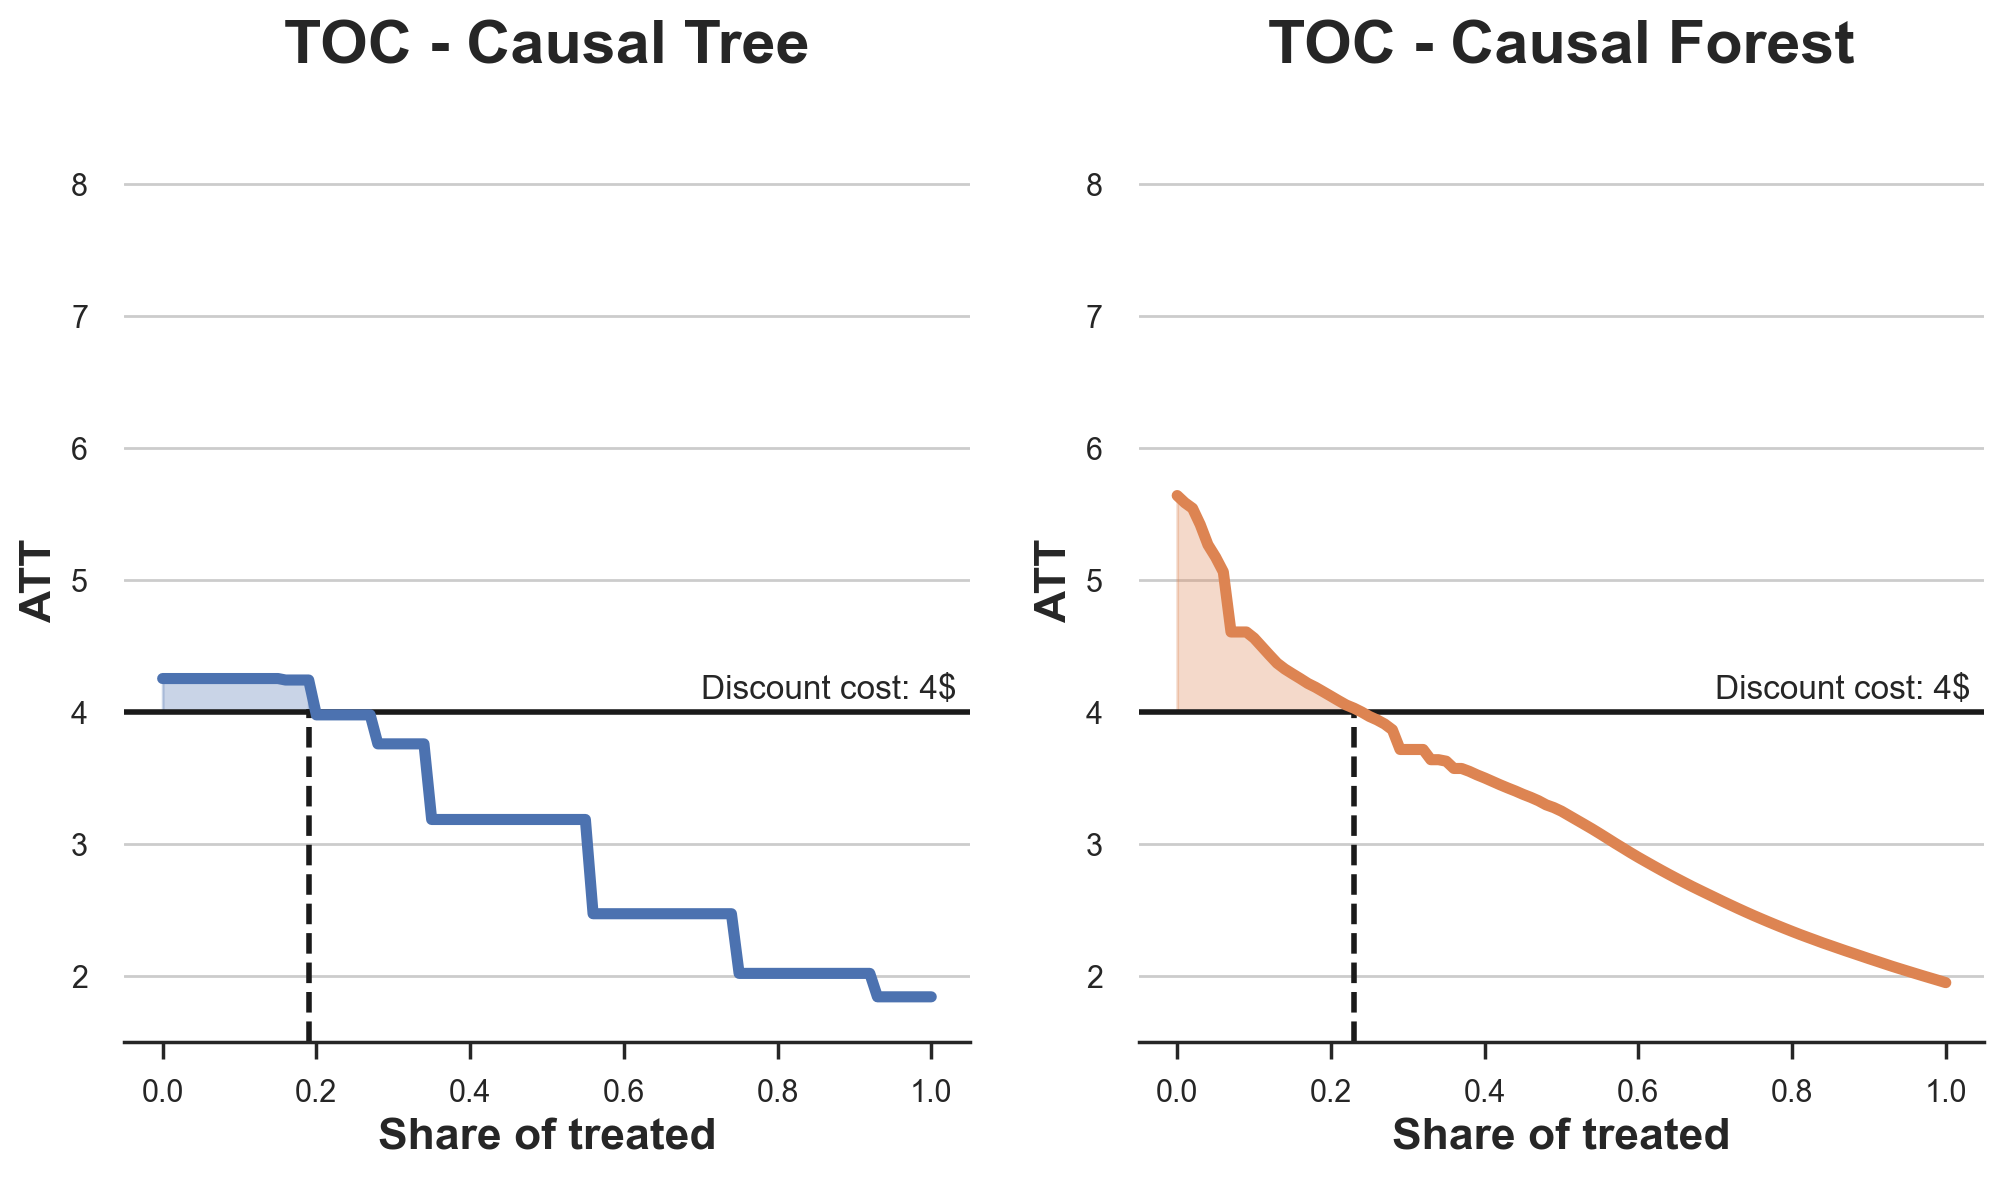

In [21]:
fix, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))
plot_toc(df_toc_tree, cost, ax1, 'C0', 'TOC - Causal Tree')
plot_toc(df_toc_forest, cost, ax2, 'C1', 'TOC - Causal Forest')

As expected, the TOC curve is decreasing for both estimators since the average effect decreases as we increase the share of treated customers. In other words, the more selective we are in releasing discounts, the higher the effect of the coupon, per customer. I have also plotted an horizontal line with the discount cost so that we can interpret the shaded area below the TOC curve and above the cost line as the **expected profits**.

The two algorims predict a similar share of treated, around 20\%, with the Causal Forest algorithm targeting slightly more customers. However, they predict very different profits. The Causal Tree algorithm predicts a small and constant margin, while the Causal Forest algorithm predicts a larger and steeper margin. Which algorithm is more accurate?

In order to compare them, we can evaluate them in the test set. We take the model trained on the training set, we predict the treatment effects and we compare them with the predictions from a model trained on the test set. Note that, differently from machine learning standard testing procedures, there is a substantial **difference**: in our case, we cannot evaluate our predictions against the ground truth, since the treatment effects are not observed. We can only compare two predictions with each other.

In [22]:
def compute_effect_test(df_test, hte_model, cost, ax, title, truth=False):
    df_test['Treated'] = hte_model.effect(df_test[X]) > cost
    if truth:
        df_test = dgp.add_treatment_effect(df_test)
        df_test['Effect'] = df_test['effect_on_spend']
    else:
        np.random.seed(0)
        hte_model_test = copy.deepcopy(hte_model).fit(Y=df_test[dgp.Y], X=df_test[X], T=df_test[dgp.D])
        df_test['Effect'] = hte_model_test.effect(df_test[X])
    df_test['Cost Effective'] = df_test['Effect'] > cost
    tot_effect = ((df_test['Effect'] - cost) * df_test['Treated']).sum()
    sns.barplot(data=df_test, x='Cost Effective', y='Treated', errorbar=None, width=0.5, ax=ax, palette=['C3', 'C2']).set(
        title=title + '\n', ylim=[0,1])
    ax.text(0.5, 1.08, f'Total effect: {tot_effect:.2f}', fontsize=14, ha='center')
    return 

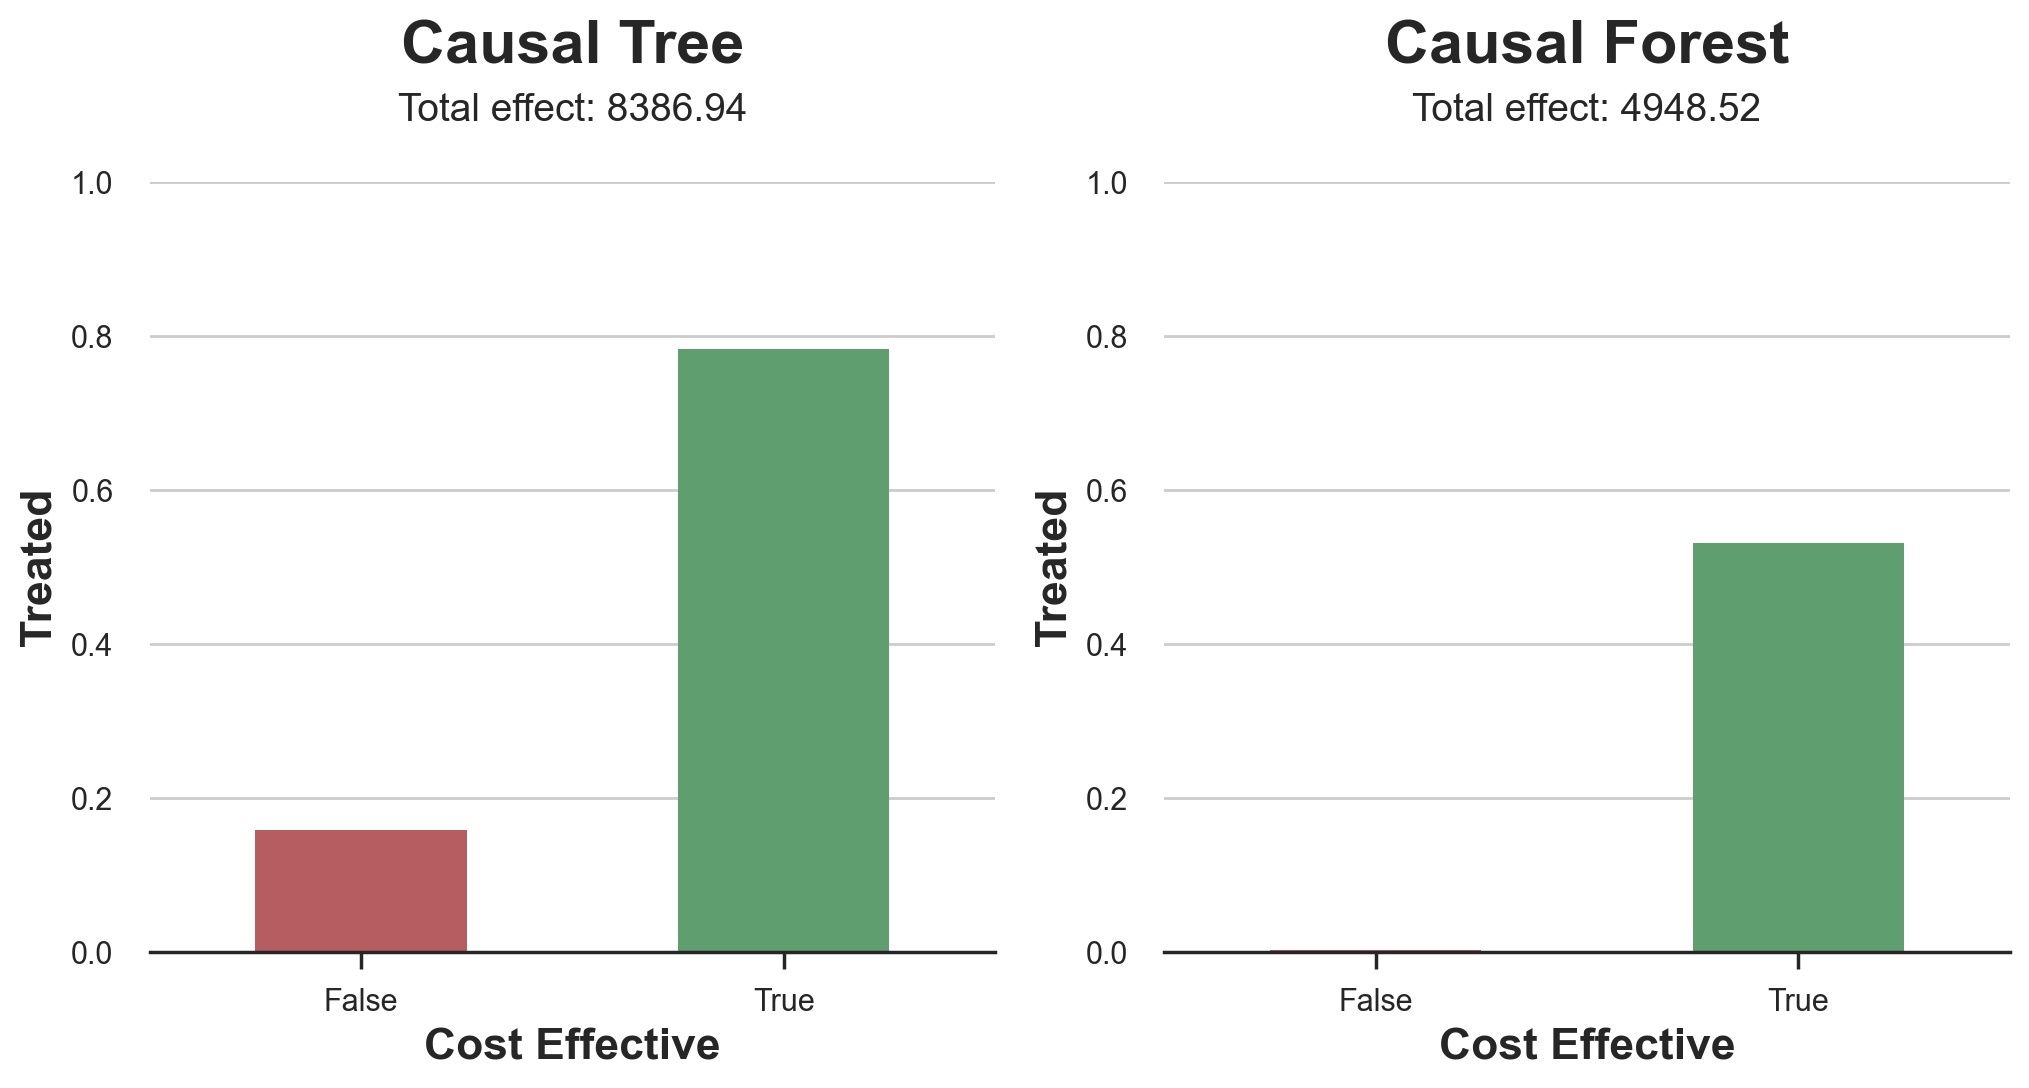

In [23]:
fix, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
compute_effect_test(df_test, tree_model, cost, ax1, 'Causal Tree')
compute_effect_test(df_test, forest_model, cost, ax2, 'Causal Forest')

It seems that the Causal Tree model performs better than the Causal Forest model, with a total net effect of $8386\$$ against $4948\$$. From the plot we can also understand the source of the discrepancy. The Causal Forest algorithm  tends to be more restrictive and treat fewer customers, making no false positives but also having a lot of false negatives. On the other hand, the Causal Tree algorithm, is much more generous and distributes the `discount` to mamy more new customers. This translates in both more true positives but also false positives. The net effect seem to favor the causal tree algorithm.

Normally, we would stop here since there is not much more we can do. However, in our case, we have access to the **true data generating process**. Therefore we can check the ground-truth accuracy of the two algorithms.

First, let's compare them in terms of prediction error of the treatment effects. For each algorithm we compute the [mean squared error](https://en.wikipedia.org/wiki/Mean_squared_error) of the treatment effects.

In [24]:
from sklearn.metrics import mean_squared_error as mse

def compute_mse_test(df_test, hte_model):
    df_test = dgp.add_treatment_effect(df_test)
    print(f"MSE = {mse(df_test['effect_on_spend'], hte_model.effect(df_test[X])):.4f}")

In [25]:
compute_mse_test(df_test, tree_model)
compute_mse_test(df_test, forest_model)

MSE = 0.9035
MSE = 0.5555


The Random Forest model better predicts the average treatment effect, with a mean squared error of $0.5555$ instead of $0.9035$. 

Does this map into a **better targeting**? We can now replicate the same barplot we did above, to understand how well the two algorithms perform in terms of policy targeting.

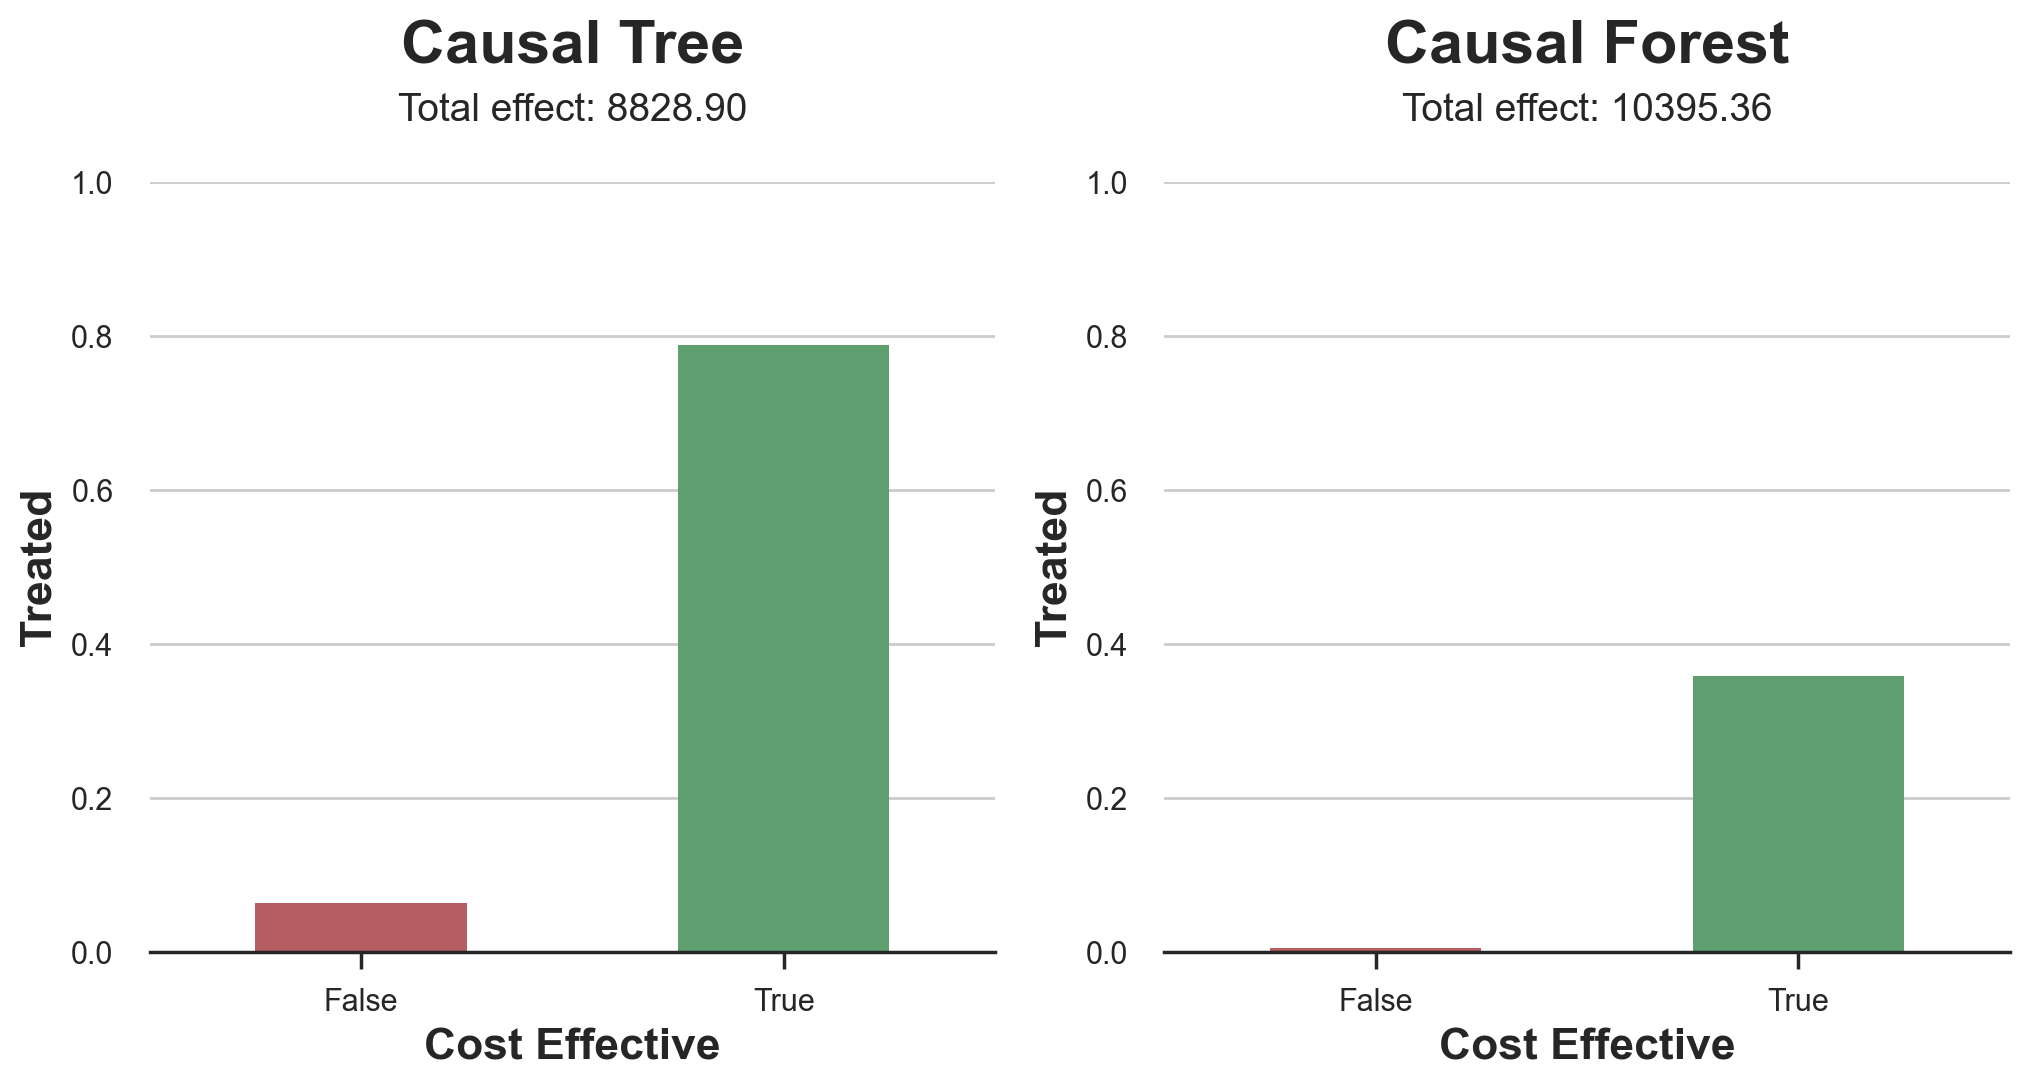

In [26]:
fix, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
compute_effect_test(df_test, tree_model, cost, ax1, 'Causal Tree', True)
compute_effect_test(df_test, forest_model, cost, ax2, 'Causal Forest', True)

The plot is very similar, but the result differ substantially. In fact, the Causal Forest algorithm now outperforms the Causal Tree algorithm with a total effect of $10395\$$ compared to $8828\$$. Why this sudden difference?

To better understand the source of the discrepancy let's plot the TOC based on the ground truth.

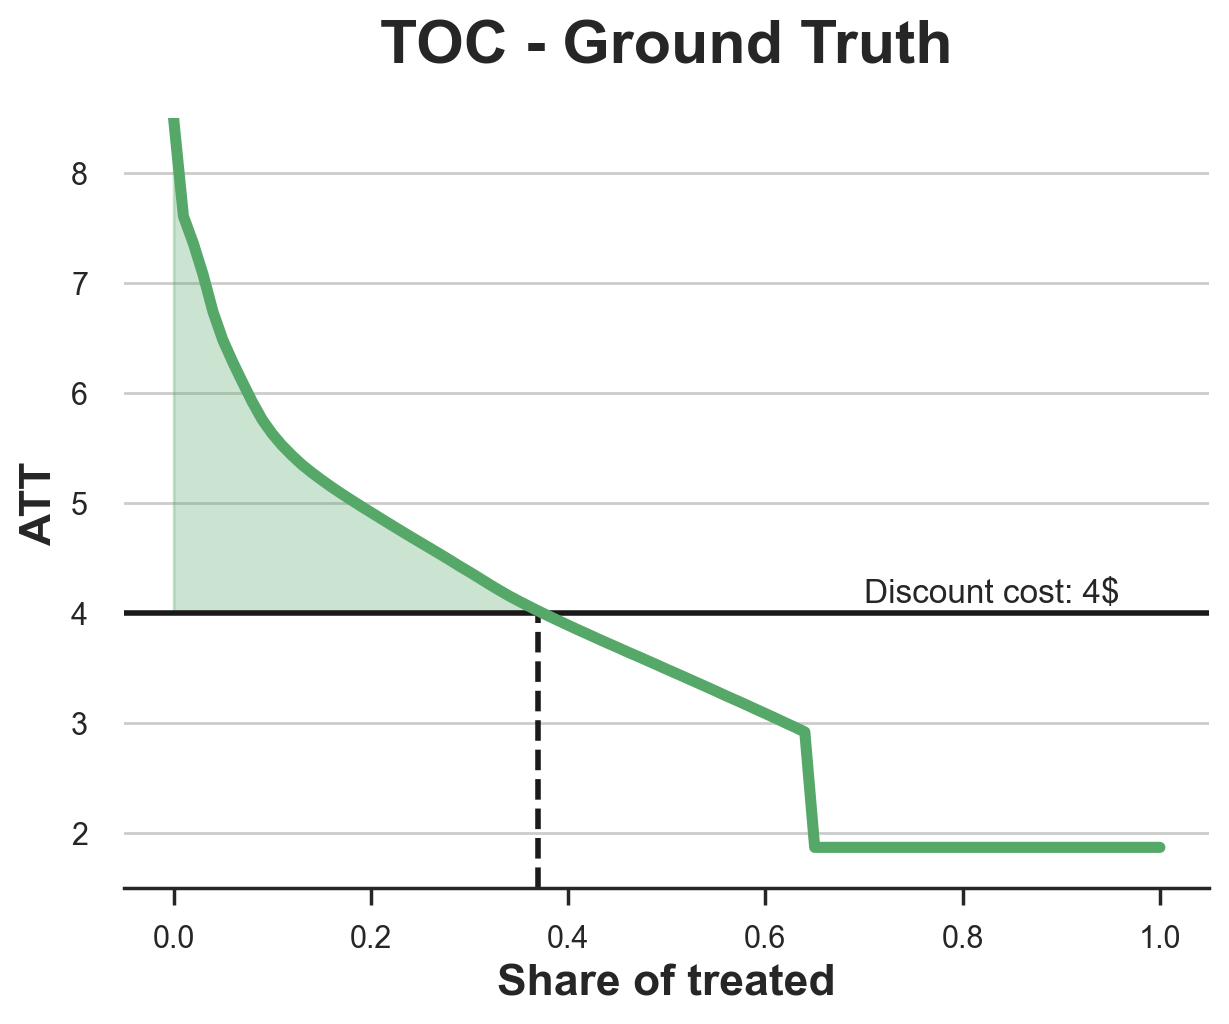

In [27]:
df_toc = compute_toc(df_test, tree_model, cost, True)

fix, ax = plt.subplots(1, 1, figsize=(7, 5))
plot_toc(df_toc, cost, ax, 'C2', 'TOC - Ground Truth')

As we can see, the TOC is very skewed and there exist a few customers with very high average treatment effects. The Random Forest algorothm is better able to indentify them and therefore is overall more effective, despite targeting fewer customers.

## Conclusion

In this post, we have seen a very powerful algorithm for the estimation of heterogeneous treatment effects: **causal forests**. Causal forests are built on the same principle of causal trees, but benefit from a much deeper exploration of the parameter space and bagging. 

We have also seen how to use the estimates of the heterogeneous treatment effects to perform policy **targeting**. By identifying users with the highest treatment effects, we are able to make profitable a policy that wouldn't be otherwise. We have also see how the objective of policy targeting might differ from the objective of heterogeneous treatment effect estimation since the tails of the distribution might be more relevant than the average.

### References

- S. Athey, G. Imbens, [Recursive partitioning for heterogeneous causal effects](https://www.pnas.org/doi/abs/10.1073/pnas.1510489113) (2016), *PNAS*.

- S. Wager, S. Athey, [Estimation and Inference of Heterogeneous Treatment Effects using Random Forests](https://www.tandfonline.com/doi/full/10.1080/01621459.2017.1319839) (2018), *Journal of the American Statistical Association*.

- S. Athey, J. Tibshirani, S. Wager, [Generalized Random Forests](https://projecteuclid.org/journals/annals-of-statistics/volume-47/issue-2/Generalized-random-forests/10.1214/18-AOS1709.full) (2019). *The Annals of Statistics*.

- M. Oprescu, V. Syrgkanis, Z. Wu, [Orthogonal Random Forest for Causal Inference](http://proceedings.mlr.press/v97/oprescu19a.html?ref=https://githubhelp.com) (2019). *Proceedings of the 36th International Conference on Machine Learning*. 

### Related Articles

- [DAGs and Control Variables](https://towardsdatascience.com/b63dc69e3d8c)

- [Matching, Weighting, or Regression?](https://towardsdatascience.com/99bf5cffa0d9)

- [Understanding Meta Learners](https://towardsdatascience.com/8a9c1e340832)

- [Understanding AIPW, the Doubly-Robust Estimator](https://towardsdatascience.com/ed4097dab27a)

- [Understanding Causal Trees](https://towardsdatascience.com/920177462149)

### Code

You can find the original Jupyter Notebook here:

https://github.com/matteocourthoud/Blog-Posts/blob/main/notebooks/causal_forests.ipynb